In [1]:
## Topic Modeling with LDA 

In [ ]:
import pandas as pd
import numpy as np

#gensim
import gensim
from gensim import corpora ## this is giving error
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel,TfidfModel


#spacy
import spacy

## visupyLDAvisze LDA
import pyLDAvis
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer
from nltk import word_tokenize

import sklearn

from wordcloud import WordCloud

from platform import python_version

import warnings
warnings.filterwarnings("ignore")

In [3]:
python_version()

'3.8.13'

In [388]:
pd.options.display.max_columns=100
pd.options.display.max_rows=100

In [389]:
## Load the Data

In [390]:
data = pd.read_excel('11210322Migrationsupportcases_copy.xlsx',sheet_name='Cases')
data.drop(columns=['Unnamed: 0'],inplace=True)

In [391]:
data.head(3)

,createdDateTime,createDay,closedDateTime,closedDay,incidentID,ICM,category,title,cause,resolution,labourMinutes,sub category,theme,manualTags,pmComments,initialSupportPath,initialSupportPathCorrect,selfHelpExists,engrComments,supportPath,rootSupportPath,region,subRegion
0,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109130010001915,NO ICM,SERVER MIGRATION,Linux VM not booting after Migration,PG found that it's failing due to the label of...,Had to manually prep the server and move over ...,2527.0,POST MIGRATION,Boot issue,"Linux, \x, escape character",NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,Root Cause - Azure Migrate\VMware agentless to...,North America,United States
1,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2107280060003266,NO ICM,SERVER MIGRATION,Azure site recovery About the matter that the ...,NaN,"Regarding this matter, we received a lot of ti...",1710.0,REPLICATION,Slow or stuck process,"Network bandwidth, limit set",NaN,Routing Azure Site Recovery V2\I am trying to ...,NaN,NaN,NaN,Routing Azure Migrate\Migrating physical serve...,Root Cause - Azure Migrate\Outage,LatAm,Argentina & Uruguay
2,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109200060001693,NO ICM,SERVER MIGRATION,Azure Migrate - Linux RH 6,Findings: 1. From the command output share I ...,You confirmed to us that your customer has opt...,451.0,POST MIGRATION,Hydration issue,NaN,NaN,Routing Azure Vmware Solution\VMware Issues\vC...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,"Root Cause - Azure Migrate\Physical servers, o...",North America,Canada


In [392]:
data['title'].fillna(value="",inplace=True)
data['cause'].fillna(value="",inplace=True)
data['resolution'].fillna(value="",inplace=True)

In [393]:
# data['title'] = data['title'].astype('str')
# data['cause'] = data['cause'].astype('str')
# data['resolution'] = data['resolution'].astype('str')

In [394]:
class TextPreprocessing:
    def __init__(self):
        nltk.download('stopwords')
        nltk.download('wordnet')
        nltk.download('omw-1.4')
        nltk.download('punkt')
        self.lemm = WordNetLemmatizer()
        self.detok = TreebankWordDetokenizer()
        self.tok= TreebankWordTokenizer()
        self.nlp = spacy.load('en_core_web_sm', disable=["parser","ner"])
        #pass;
        
    def simple_prep_process(self, data): ## lowercases, tokenizes, and de-accents the text
        return data.apply(lambda x:  gensim.utils.simple_preprocess(x, deacc=True)) ## deacc is true to de-accent

    
    def stopwords_removal(self, text): ## Remove stop words
        text = [word for word in text if word not in stopwords.words('english')]
        return text

    
    def lemmatizer(self,text): ## lemmatizes the words in the text
        #return self.tokenize(' '.join([self.lemm.lemmatize(w) for w in text])) ## nltk lemmatizer
        allowed_postags=["NOUN","VERB","ADV","ADJ","PROPN"]
        text = " ".join([x for x in text])
        doc = self.nlp(text) ## spacy lemmatizer
        return [token.lemma_ for token in doc if token.pos_ in allowed_postags]
    
    def detokenize(self,text):
        return self.detok.detokenize(text)

    def tokenize(self,text):
        return self.tok.tokenize(text)

In [395]:
tp = TextPreprocessing()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\manpresingh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\manpresingh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\manpresingh\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\manpresingh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [396]:
%%time
## Simple Preprocessing using Gensim:
data['title_SP'] = tp.simple_prep_process(data['title'])
data['cause_SP'] = tp.simple_prep_process(data['cause']) 
data['resolution_SP'] = tp.simple_prep_process(data['resolution']) 

CPU times: total: 172 ms
Wall time: 161 ms


In [397]:
%%time
## Lemmatization
data['title_SP_lemmatized']=data['title_SP'].apply(lambda x : tp.lemmatizer(x))
data['cause_SP_lemmatized']=data['cause_SP'].apply(lambda x : tp.lemmatizer(x))
data['resolution_SP_lemmatized']=data['resolution_SP'].apply(lambda x : tp.lemmatizer(x))

CPU times: total: 5.61 s
Wall time: 5.6 s


In [398]:
%%time
## Remove stopwords
data['title_SP_lemmatized_SW']=data['title_SP_lemmatized'].apply(lambda x : tp.stopwords_removal(x))
data['cause_SP_lemmatized_SW']=data['cause_SP_lemmatized'].apply(lambda x : tp.stopwords_removal(x))
data['resolution_SP_lemmatized_SW']=data['resolution_SP_lemmatized'].apply(lambda x : tp.stopwords_removal(x))

CPU times: total: 5.5 s
Wall time: 5.5 s


In [399]:
%%time
## detokenize
data['title_SP_lemmatized_SW_detok']=data['title_SP_lemmatized_SW'].apply(lambda x : tp.detokenize(x))
data['cause_SP_lemmatized_SW_detok']=data['cause_SP_lemmatized_SW'].apply(lambda x : tp.detokenize(x))
data['resolution_SP_lemmatized_SW_detok']=data['resolution_SP_lemmatized_SW'].apply(lambda x : tp.detokenize(x))

CPU times: total: 156 ms
Wall time: 157 ms


In [400]:
data.head(2)

,createdDateTime,createDay,closedDateTime,closedDay,incidentID,ICM,category,title,cause,resolution,labourMinutes,sub category,theme,manualTags,pmComments,initialSupportPath,initialSupportPathCorrect,selfHelpExists,engrComments,supportPath,rootSupportPath,region,subRegion,title_SP,cause_SP,resolution_SP,title_SP_lemmatized,cause_SP_lemmatized,resolution_SP_lemmatized,title_SP_lemmatized_SW,cause_SP_lemmatized_SW,resolution_SP_lemmatized_SW,title_SP_lemmatized_SW_detok,cause_SP_lemmatized_SW_detok,resolution_SP_lemmatized_SW_detok
0,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109130010001915,NO ICM,SERVER MIGRATION,Linux VM not booting after Migration,PG found that it's failing due to the label of...,Had to manually prep the server and move over ...,2527.0,POST MIGRATION,Boot issue,"Linux, \x, escape character",NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,Root Cause - Azure Migrate\VMware agentless to...,North America,United States,"[linux, vm, not, booting, after, migration]","[pg, found, that, it, failing, due, to, the, l...","[had, to, manually, prep, the, server, and, mo...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, have, name, actu...","[manually, prep, server, move, datum, disk, do...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, name, actually, ...","[manually, prep, server, move, datum, disk, av...",linux vm boot migration,pg find fail label disk name actually escape c...,manually prep server move datum disk avoid dis...
1,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2107280060003266,NO ICM,SERVER MIGRATION,Azure site recovery About the matter that the ...,,"Regarding this matter, we received a lot of ti...",1710.0,REPLICATION,Slow or stuck process,"Network bandwidth, limit set",NaN,Routing Azure Site Recovery V2\I am trying to ...,NaN,NaN,NaN,Routing Azure Migrate\Migrating physical serve...,Root Cause - Azure Migrate\Outage,LatAm,Argentina & Uruguay,"[azure, site, recovery, about, the, matter, th...",[],"[regarding, this, matter, we, received, lot, o...","[azure, site, recovery, matter, bandwidth, con...",[],"[regard, matter, receive, lot, time, cooperati...","[azure, site, recovery, matter, bandwidth, con...",[],"[regard, matter, receive, lot, time, cooperati...",azure site recovery matter bandwidth control p...,,regard matter receive lot time cooperation con...


In [401]:
## concatenate title + cause & detokenize

In [402]:
data['concatenated_text_detok']= data['title_SP_lemmatized_SW_detok'] + " " + data['cause_SP_lemmatized_SW_detok']

data['concatenated_text_tok']= data['concatenated_text_detok'].apply(lambda x: tp.tokenize(x))

In [403]:
data.head(2)

,createdDateTime,createDay,closedDateTime,closedDay,incidentID,ICM,category,title,cause,resolution,labourMinutes,sub category,theme,manualTags,pmComments,initialSupportPath,initialSupportPathCorrect,selfHelpExists,engrComments,supportPath,rootSupportPath,region,subRegion,title_SP,cause_SP,resolution_SP,title_SP_lemmatized,cause_SP_lemmatized,resolution_SP_lemmatized,title_SP_lemmatized_SW,cause_SP_lemmatized_SW,resolution_SP_lemmatized_SW,title_SP_lemmatized_SW_detok,cause_SP_lemmatized_SW_detok,resolution_SP_lemmatized_SW_detok,concatenated_text_detok,concatenated_text_tok
0,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109130010001915,NO ICM,SERVER MIGRATION,Linux VM not booting after Migration,PG found that it's failing due to the label of...,Had to manually prep the server and move over ...,2527.0,POST MIGRATION,Boot issue,"Linux, \x, escape character",NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,Root Cause - Azure Migrate\VMware agentless to...,North America,United States,"[linux, vm, not, booting, after, migration]","[pg, found, that, it, failing, due, to, the, l...","[had, to, manually, prep, the, server, and, mo...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, have, name, actu...","[manually, prep, server, move, datum, disk, do...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, name, actually, ...","[manually, prep, server, move, datum, disk, av...",linux vm boot migration,pg find fail label disk name actually escape c...,manually prep server move datum disk avoid dis...,linux vm boot migration pg find fail label dis...,"[linux, vm, boot, migration, pg, find, fail, l..."
1,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2107280060003266,NO ICM,SERVER MIGRATION,Azure site recovery About the matter that the ...,,"Regarding this matter, we received a lot of ti...",1710.0,REPLICATION,Slow or stuck process,"Network bandwidth, limit set",NaN,Routing Azure Site Recovery V2\I am trying to ...,NaN,NaN,NaN,Routing Azure Migrate\Migrating physical serve...,Root Cause - Azure Migrate\Outage,LatAm,Argentina & Uruguay,"[azure, site, recovery, about, the, matter, th...",[],"[regarding, this, matter, we, received, lot, o...","[azure, site, recovery, matter, bandwidth, con...",[],"[regard, matter, receive, lot, time, cooperati...","[azure, site, recovery, matter, bandwidth, con...",[],"[regard, matter, receive, lot, time, cooperati...",azure site recovery matter bandwidth control p...,,regard matter receive lot time cooperation con...,azure site recovery matter bandwidth control p...,"[azure, site, recovery, matter, bandwidth, con..."


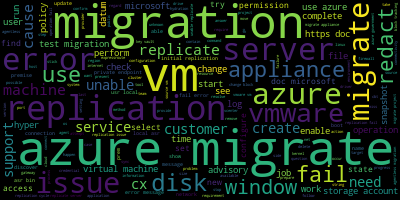

In [404]:
WordCloud().generate(" ".join(data['concatenated_text_detok'].tolist())).to_image()

In [405]:
from collections import Counter
Counter(data.concatenated_text_detok[8].split()).most_common()

[('server', 1),
 ('stick', 1),
 ('migration', 1),
 ('ir', 1),
 ('occupy', 1),
 ('bandwidth', 1),
 ('get', 1),
 ('auto', 1),
 ('resolve', 1),
 ('later', 1)]

In [406]:
data.concatenated_text_detok.str.split(expand=True).stack().value_counts().tail(100)

manual             1
hkhs               1
kms                1
alwayson           1
speak              1
storflt            1
wms                1
systemroot         1
incomplete         1
interrupted        1
vddk               1
library            1
official           1
fs                 1
red                1
edition            1
assignment         1
artifact           1
rdm                1
secure             1
outdated           1
recalculation      1
mysql              1
acquisition        1
much               1
produce            1
nslookup           1
your_vault_name    1
aur                1
bpm                1
permiite           1
achieve            1
residual           1
behind             1
sso                1
obvious            1
migarte            1
vdi                1
waagent            1
opening            1
thing              1
abrs               1
concern            1
hat                1
exclusion          1
chroot             1
ivirtualmachine    1
oneway       

In [407]:
## Bigrams and Trigrams

In [408]:
# bigram_phrases = gensim.models.Phrases(data['concatenated_text_tok'], min_count=2, threshold=50)
# trigram_phrases = gensim.models.Phrases(bigram_phrases[data['concatenated_text_tok']], min_count=2, threshold=50)

# bigram = gensim.models.phrases.Phraser(bigram_phrases)
# trigram = gensim.models.phrases.Phraser(trigram_phrases)

# def make_bigrams(texts):
#     return (bigram[doc] for doc in texts)

# def make_trigrams(texts):
#     return (trigram[bigram[doc]] for doc in texts)          


# data_bigrams = make_bigrams(data['concatenated_text_tok'])
# data_bigrams_trigrams = make_trigrams(data_bigrams)


In [409]:
#next(data_bigrams)

In [410]:
## Verification of how corpus and id2word work

# id2word = corpora.Dictionary([['My', 'Name', 'is', 'Sahil', 'and', 'I', 'am', 'Sahil', 'Singh'],['I','am','Manpreet']])

# print(id2word)

# [id2word.doc2bow(text) for text in [['My', 'Name', 'is', 'Sahil', 'and', 'I', 'am', 'Sahil', 'Singh'],['I','am','Manpreet']]]

In [411]:
## 

In [412]:
word_df = pd.DataFrame(data.concatenated_text_detok.str.split(expand=True).stack().value_counts())
word_df.reset_index(inplace=True)
word_df.rename(columns={'index':'word',0:'Frequency'},inplace=True)

In [413]:
word_df.shape

(1703, 2)

In [414]:
word_df.head()

,word,Frequency
0,azure,447
1,migrate,401
2,migration,277
3,replication,257
4,vm,225


In [415]:
def word_count(text):
    return data.concatenated_text_detok.str.contains(text).sum()

In [416]:
word_df['Doc_Presence_Count']=word_df['word'].apply(lambda x: word_count(x))

In [417]:
word_df_2= word_df[(word_df.Frequency>3) & (word_df.Doc_Presence_Count<int(len(data)*.6))]

In [418]:
word_df_2.shape

(543, 3)

In [419]:
word_df_2.head()

,word,Frequency,Doc_Presence_Count
0,azure,447,294
1,migrate,401,266
2,migration,277,198
3,replication,257,185
4,vm,225,229


In [420]:
#[word for word in data.concatenated_text_tok[0]]

In [421]:
mylambdafunc = lambda i: [word for word in data.concatenated_text_tok[i] if word_df_2.word.str.contains(word).any() ]

In [422]:
data['concatenated_text_tok_wordcount']=[mylambdafunc(i) for i in range(0,len(data))]

In [423]:
data.head(1)

,createdDateTime,createDay,closedDateTime,closedDay,incidentID,ICM,category,title,cause,resolution,labourMinutes,sub category,theme,manualTags,pmComments,initialSupportPath,initialSupportPathCorrect,selfHelpExists,engrComments,supportPath,rootSupportPath,region,subRegion,title_SP,cause_SP,resolution_SP,title_SP_lemmatized,cause_SP_lemmatized,resolution_SP_lemmatized,title_SP_lemmatized_SW,cause_SP_lemmatized_SW,resolution_SP_lemmatized_SW,title_SP_lemmatized_SW_detok,cause_SP_lemmatized_SW_detok,resolution_SP_lemmatized_SW_detok,concatenated_text_detok,concatenated_text_tok,concatenated_text_tok_wordcount
0,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109130010001915,NO ICM,SERVER MIGRATION,Linux VM not booting after Migration,PG found that it's failing due to the label of...,Had to manually prep the server and move over ...,2527.0,POST MIGRATION,Boot issue,"Linux, \x, escape character",NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,Root Cause - Azure Migrate\VMware agentless to...,North America,United States,"[linux, vm, not, booting, after, migration]","[pg, found, that, it, failing, due, to, the, l...","[had, to, manually, prep, the, server, and, mo...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, have, name, actu...","[manually, prep, server, move, datum, disk, do...","[linux, vm, boot, migration]","[pg, find, fail, label, disk, name, actually, ...","[manually, prep, server, move, datum, disk, av...",linux vm boot migration,pg find fail label disk name actually escape c...,manually prep server move datum disk avoid dis...,linux vm boot migration pg find fail label dis...,"[linux, vm, boot, migration, pg, find, fail, l...","[linux, vm, boot, migration, pg, find, fail, d..."


In [424]:
text_data=data['concatenated_text_tok_wordcount']

In [425]:
def func_dict(text_data):
    id2word = corpora.Dictionary(text_data)
    
    corpus = [id2word.doc2bow(text) for text in text_data]
    ## corpus is baically x,y representation of the tokens in the given data
    
    return id2word, corpus

In [426]:
id2word, corpus =func_dict(text_data)

In [427]:
tfidf = TfidfModel(corpus=corpus, id2word=id2word)

In [428]:
text_data[0]
#Here we have the word "actually" at 9th position, but in id2word dictionary this word is the the first word with index as 0.
#Hence, x is 0 in the first x,y pair of corpus[0][0:5]

#Then for y, we check the frequence of this word in this sentence, which is data['concatenated_text_tok'][0]. We see it's 1. hence, y is 1

#There we have x,y as 0,1 as printed in the next cell

['linux',
 'vm',
 'boot',
 'migration',
 'pg',
 'find',
 'fail',
 'disk',
 'name',
 'character',
 'cause',
 'script',
 'stop',
 'finish',
 'https',
 'redact',
 'imp',
 'incident',
 'detail']

In [429]:
corpus[0] ##(x,y):  is the index-number of the word as per the id2word dictionary . y is the frequency i.e. how many times that word has occured

[(0, 1),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 1),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1)]

In [430]:
pd.DataFrame(tfidf[corpus[0]],[id2word[id] for id,value in corpus[0]], columns=['Index_Position','TF-IDF_value'])

,Index_Position,TF-IDF_value
boot,0,0.213768
cause,1,0.149595
character,2,0.306448
detail,3,0.225003
disk,4,0.148398
fail,5,0.111265
find,6,0.198664
finish,7,0.306448
https,8,0.196041
imp,9,0.391869


In [431]:
len(corpus[0])

19

In [432]:
len(text_data[0])

19

In [433]:
id2word[0] ## word at 0th index is "actually" and this word has occured only once in the given text, which hereb is data['cause_SP_lemmatized_SW'][0]

'boot'

In [434]:
def func_tfidf_imp_words(corpus, id2word,cut_off=.2):
    
    corpus = corpus
    id2word=id2word
    low_value = cut_off
    words = []
    words_missing_in_tfidf=[]
    
    tfidf = TfidfModel(corpus=corpus, id2word=id2word)
    
    for i in range(0, len(corpus)):
        bow = corpus[i]
        low_value_words = []
        tfidf_ids = [id for id,value in tfidf[bow]]
        bow_ids = [id for id,value in bow]
        low_value_words = [id for id,value in tfidf[bow] if value < low_value] ## add a condition to preserve some important words from a predefined dictionary - SlD (Support Language Dictionary)
        drops = low_value_words + words_missing_in_tfidf
        for item in drops:
            words.append(id2word[item])
        words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] 
    
        new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf] ## b[0] is the index of the word
        corpus[i] = new_bow
    return corpus

In [435]:
corpus = func_tfidf_imp_words(corpus, id2word, cut_off=.1)

In [436]:
tfidf[corpus[0]]

[(0, 0.21491040042560283),
 (1, 0.1503943353140093),
 (2, 0.30808510322202304),
 (3, 0.22620487031396605),
 (4, 0.14919142223088697),
 (5, 0.11185945586288781),
 (6, 0.19972553545462246),
 (7, 0.30808510322202304),
 (8, 0.19708904917200107),
 (9, 0.39396337342443893),
 (10, 0.32590645447562483),
 (11, 0.2083835190603643),
 (13, 0.22620487031396605),
 (14, 0.2829673193744169),
 (15, 0.17736145282956753),
 (16, 0.26514596812081515),
 (17, 0.19708904917200107)]

In [437]:
[id for id,value in corpus[0]]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]

In [438]:
[id2word[id] for id,value in corpus[0]]

['boot',
 'cause',
 'character',
 'detail',
 'disk',
 'fail',
 'find',
 'finish',
 'https',
 'imp',
 'incident',
 'linux',
 'name',
 'pg',
 'redact',
 'script',
 'stop']

In [439]:
len(corpus[0]) ### 22 reduced to 5

17

In [440]:
tfidf[corpus[0]]

[(0, 0.21491040042560283),
 (1, 0.1503943353140093),
 (2, 0.30808510322202304),
 (3, 0.22620487031396605),
 (4, 0.14919142223088697),
 (5, 0.11185945586288781),
 (6, 0.19972553545462246),
 (7, 0.30808510322202304),
 (8, 0.19708904917200107),
 (9, 0.39396337342443893),
 (10, 0.32590645447562483),
 (11, 0.2083835190603643),
 (13, 0.22620487031396605),
 (14, 0.2829673193744169),
 (15, 0.17736145282956753),
 (16, 0.26514596812081515),
 (17, 0.19708904917200107)]

In [441]:
len(corpus)

578

In [442]:
## Elbow Curve to optimize the nujmber of topics

In [470]:
def my_lda_model(num_topics=5,id2word=id2word, corpus=corpus):
    lda_model = gensim.models.ldamodel.LdaModel(
                                            corpus = corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=100,
                                            update_every=1,
                                            chunksize=80,
                                            passes=30,
                                            alpha="auto" ,
                                            iterations=30
                                            )
    
    return lda_model

In [471]:
# final_model= my_lda_model(num_topics=4,id2word=id2word, corpus=corpus)
# cm = CoherenceModel(model=final_model, texts=text_data, dictionary=id2word, coherence='c_v')
# cm.get_coherence()

0.5005734914173521

In [212]:
#lda_model.log_perplexity(corpus)

In [472]:
def func_topic_modelling(id2word, corpus, texts, min_topics=5, max_num_topics=30, topic_step=2):
    coherence_values, model_list,num_topics = [],[],[]
    for topic in range(min_topics, max_num_topics, topic_step):
        #print(topic)
        model = my_lda_model(num_topics=topic,id2word=id2word, corpus=corpus)
        model_list.append(model)
        cm = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(round(cm.get_coherence(),2))
        num_topics.append(topic)
    coherence_dict = {"Num_Topics":num_topics,"Coherence_value":coherence_values,"Model":model_list}    
    return model_list, coherence_values, coherence_dict    

In [473]:
%%time
min_topics, max_num_topics, topic_step = 2,21,1
model_list, coherence_values,coherence_dict = func_topic_modelling(id2word=id2word, 
                                                    corpus=corpus, 
                                                    texts=text_data, 
                                                    min_topics=min_topics, 
                                                    max_num_topics=max_num_topics, 
                                                    topic_step=topic_step)

CPU times: total: 52.2 s
Wall time: 1min 44s


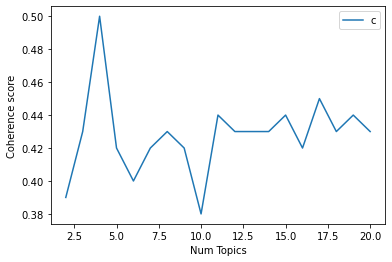

In [474]:
x = range(min_topics, max_num_topics, topic_step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [475]:
coherence_df = pd.DataFrame(coherence_dict)
coherence_df.sort_values(by='Coherence_value',ascending=False,inplace=True)
coherence_df.reset_index(drop=True,inplace=True)

In [476]:
coherence_df.head(4)

,Num_Topics,Coherence_value,Model
0,4,0.50,"LdaModel(num_terms=672, num_topics=4, decay=0...."
1,17,0.45,"LdaModel(num_terms=672, num_topics=17, decay=0..."
2,11,0.44,"LdaModel(num_terms=672, num_topics=11, decay=0..."
3,19,0.44,"LdaModel(num_terms=672, num_topics=19, decay=0..."


In [511]:
final_model = coherence_df['Model'][2]

In [512]:
final_model

In [513]:
final_model.top_topics

<bound method LdaModel.top_topics of <gensim.models.ldamodel.LdaModel object at 0x00000248F15928B0>>

In [514]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(final_model,corpus,id2word, mds="mmds", R=10)
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.268893 -0.301707       1        1  22.477375
10     0.417078 -0.075045       2        1  16.360697
8      0.363568  0.203368       3        1  12.164238
0      0.100438  0.416117       4        1   8.095203
2     -0.006156 -0.413558       5        1   7.758802
7     -0.401211 -0.035453       6        1   6.745605
9     -0.279187 -0.288611       7        1   6.643948
4     -0.270814  0.123988       8        1   5.448767
3     -0.219231  0.347052       9        1   5.351121
5      0.050515  0.148798      10        1   4.648663
6     -0.023894 -0.124949      11        1   4.305582, topic_info=          Term        Freq       Total Category  logprob  loglift
19       azure  202.000000  202.000000  Default  10.0000  10.0000
61     migrate  176.000000  176.000000  Default   9.0000   9.0000
12   migration  149.000000  149.000000  Default   8.0000   8.0000
56       issue  113.000000  113.000000  Default   7.0000   7.0000
5         fail   83.000000   83.000000  Default   6.0000   6.0000
..         ...         ...         ...      ...      ...      ...
85        show   14.423183   15.280841  Topic11  -3.0908   3.0875
301   internet   10.996488   11.854213  Topic11  -3.3621   3.0702
102        usr   10.867496   11.725093  Topic11  -3.3739   3.0693
32         bin    9.456435   10.314031  Topic11  -3.5129   3.0584
4         disk   16.654792   66.145514  Topic11  -2.9469   1.7661

[132 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
413       7  0.934006        _
393       9  0.943439   access
211       6  0.567334  account
211      10  0.425500  account
26        4  0.879718      add
...     ...       ...      ...
18        3  0.604277       vm
104       5  0.978820      vms
105       1  0.989222   vmware
195       8  0.976625  windows
25        5  0.968828     work

[129 rows x 3 columns], R=10, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 9, 1, 3, 8, 10, 5, 4, 6, 7])

In [515]:
final_model.print_topics()

[(0,
  '0.189*"issue" + 0.145*"appliance" + 0.134*"use" + 0.035*"vcenter" + 0.027*"move" + 0.021*"instal" + 0.019*"kernel" + 0.018*"database" + 0.018*"add" + 0.016*"know"'),
 (1,
  '0.097*"replication" + 0.069*"server" + 0.060*"vmware" + 0.059*"error" + 0.045*"replicate" + 0.044*"machine" + 0.037*"vm" + 0.031*"cause" + 0.029*"get" + 0.027*"unable"'),
 (2,
  '0.071*"work" + 0.068*"vms" + 0.051*"change" + 0.048*"perform" + 0.047*"host" + 0.043*"need" + 0.034*"miss" + 0.029*"application" + 0.028*"boot" + 0.027*"ip"'),
 (3,
  '0.083*"private" + 0.071*"government" + 0.058*"block" + 0.052*"endpoint" + 0.046*"access" + 0.046*"project" + 0.032*"connection" + 0.027*"ja" + 0.027*"jp" + 0.024*"tracking"'),
 (4,
  '0.207*"fail" + 0.065*"service" + 0.044*"resource" + 0.044*"windows" + 0.041*"initial" + 0.035*"process" + 0.029*"hydration" + 0.026*"console" + 0.023*"properly" + 0.023*"error"'),
 (5,
  '0.094*"operation" + 0.084*"permission" + 0.067*"expressroute" + 0.060*"state" + 0.044*"account" + 0

In [582]:
topics = final_model.show_topics(num_topics=11,num_words=5,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in topics]
topics_words

[(0, ['issue', 'appliance', 'use', 'vcenter', 'move']),
 (1, ['replication', 'server', 'vmware', 'error', 'replicate']),
 (2, ['work', 'vms', 'change', 'perform', 'host']),
 (3, ['private', 'government', 'block', 'endpoint', 'access']),
 (4, ['fail', 'service', 'resource', 'windows', 'initial']),
 (5, ['operation', 'permission', 'expressroute', 'state', 'account']),
 (6, ['asr', 'local', 'version', 'memory', 'disk']),
 (7, ['error', 'storage', 'message', 'user', 'gateway']),
 (8, ['migration', 'vm', 'cx', 'test', 'complete']),
 (9, ['set', 'redact', 'policy', 'configure', 'queue']),
 (10, ['azure', 'migrate', 'microsoft', 'com', 'support'])]

In [ ]:
from operator import itemgetter

In [650]:
index = 210

In [651]:
test_data = data.concatenated_text_tok_wordcount[index]

In [652]:
data.manualTags[index]

'Windows server 2008'

In [653]:
data.title[index]

'Test migration fails'

In [654]:
data.cause[index]

'In general speaking, after we apply the Windows Server 2008 Service pack 2 on a Windows Server 2008, all the system drive files (s3cap.sys, storflt.sys, wms3cap.sys, vmstorfl.sys) will still exist under the path "%systemroot%\\System32\\Drivers" on Windows Server 2008 SP2-based virtual machine. These drive files won’t be removed after applying Windows Server 2008 Service Pack 2. And the possible reason why the drive files are lost may result from the incomplete or interrupted application of SP2.'

In [655]:
data.resolution[index]

'Re-apply the Windows Server 2008 Service pack 2 on the problematic server.  Copy the files from a working machine to the non-working machine. This can take you 5 minutes or less. You need to find a working server 2008 SP2 and copy the missing files from C:\\Windows\\System32\\Drivers into the non-working server under the same location C:\\Windows\\System32\\Drivers.  *** If you do not have permissions to paste the files under C:\\Windows\\System32\\Drivers, you just need to take ownership and full permission of C:\\Windows\\System32\\Drivers folder.'

In [656]:
x = final_model[id2word.doc2bow(test_data)]
val = [value for id,value in final_model[id2word.doc2bow(test_data)]]
val.sort(reverse=True)

## Getting top 3 topics and their top 2 words
ids = [id for id,value in x if value > val[3]] 
[topics_words[id][1][0:2] for id in ids]

[['replication', 'server'], ['fail', 'service'], ['azure', 'migrate']]

0.113138214

[['replication', 'server'], ['operation', 'permission'], ['migration', 'vm']]

In [572]:
# x=final_model[id2word.doc2bow(test_data)]
# id_max = max(x, key=itemgetter(1))[0]
# value_max = max(x, key=itemgetter(1))[1]

In [576]:
test_data

['prepare',
 'test',
 'migration',
 'migration',
 'virtual',
 'machine',
 'fail',
 'azure',
 'platform',
 'error',
 'customer',
 'policy',
 'place',
 'require',
 'vnet',
 'create',
 'need',
 'protection',
 'plan',
 'enable',
 'customer',
 'account',
 'permission',
 'assign',
 'protection',
 'plan']

In [517]:
pd.DataFrame(tfidf[corpus[23]],[id2word[id] for id,value in corpus[23]], columns=['Index_Position','TF-IDF_value'])

,Index_Position,TF-IDF_value
migration,12,0.107040
create,39,0.148784
need,62,0.136670
test,96,0.116960
customer,122,0.260736
machine,184,0.102882
virtual,194,0.135344
enable,200,0.138033
plan,204,0.438918
account,211,0.150529


In [500]:
data.manualTags[23]

'Azure VNet policy'

In [502]:
data['theme'][23]

'Permission issue'

In [510]:
data.concatenated_text_tok[23]

['prepare',
 'test',
 'migration',
 'migration',
 'virtual',
 'machine',
 'fail',
 'azure',
 'platform',
 'error',
 'customer',
 'policy',
 'place',
 'require',
 'vnet',
 'create',
 'need',
 'ddo',
 'protection',
 'plan',
 'enable',
 'customer',
 'account',
 'permission',
 'assign',
 'ddos',
 'protection',
 'plan']

In [507]:
nlp = spacy.load('en_core_web_sm', disable=["parser","ner"])
allowed_postags=["NOUN","VERB","ADV","ADJ","PROPN"]
text = " ".join([x for x in data.cause_SP[23]])
doc = nlp(text) ## spacy lemmatizer
[token.lemma_ for token in doc if token.pos_ in allowed_postags]

['customer',
 'policy',
 'place',
 'require',
 'vnet',
 'create',
 'need',
 'ddo',
 'protection',
 'plan',
 'enable',
 'customer',
 'account',
 'permission',
 'assign',
 'ddos',
 'protection',
 'plan']

In [385]:
[token.pos_ for token in doc]

['VERB',
 'NOUN',
 'NOUN',
 'ADP',
 'NOUN',
 'NOUN',
 'NOUN',
 'CCONJ',
 'PART',
 'ADJ',
 'PART',
 'VERB',
 'NOUN']

In [504]:
doc

preparing for test migration migration for the virtual machine failed because of an azure platform error

In [329]:
data.title_SP[1]

['azure',
 'site',
 'recovery',
 'about',
 'the',
 'matter',
 'that',
 'the',
 'bandwidth',
 'control',
 'of',
 'the',
 'provider',
 'does',
 'not',
 'work']

In [324]:
data.head(2)

,createdDateTime,createDay,closedDateTime,closedDay,incidentID,ICM,category,title,cause,resolution,labourMinutes,sub category,theme,manualTags,pmComments,initialSupportPath,initialSupportPathCorrect,selfHelpExists,engrComments,supportPath,rootSupportPath,region,subRegion,title_SP,cause_SP,resolution_SP,title_SP_lemmatized,cause_SP_lemmatized,resolution_SP_lemmatized,title_SP_lemmatized_SW,cause_SP_lemmatized_SW,resolution_SP_lemmatized_SW,title_SP_lemmatized_SW_detok,cause_SP_lemmatized_SW_detok,resolution_SP_lemmatized_SW_detok,concatenated_text_detok,concatenated_text_tok,concatenated_text_tok_wordcount
0,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2109130010001915,NO ICM,SERVER MIGRATION,Linux VM not booting after Migration,PG found that it's failing due to the label of...,Had to manually prep the server and move over ...,2527.0,POST MIGRATION,Boot issue,"Linux, \x, escape character",NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,NaN,NaN,NaN,Routing Azure Migrate\Migrating VMware VMs (ag...,Root Cause - Azure Migrate\VMware agentless to...,North America,United States,"[linux, vm, not, booting, after, migration]","[pg, found, that, it, failing, due, to, the, l...","[had, to, manually, prep, the, server, and, mo...","[linux, boot, migration]","[find, fail, label, disk, have, name, actually...","[manually, prep, server, move, datum, disk, do...","[linux, boot, migration]","[find, fail, label, disk, name, actually, esca...","[manually, prep, server, move, datum, disk, av...",linux boot migration,find fail label disk name actually escape char...,manually prep server move datum disk avoid dis...,linux boot migration find fail label disk name...,"[linux, boot, migration, find, fail, label, di...","[linux, boot, migration, find, fail, disk, nam..."
1,2021-10-15,15-10-2021,2021-11-01,01-11-2021,2107280060003266,NO ICM,SERVER MIGRATION,Azure site recovery About the matter that the ...,,"Regarding this matter, we received a lot of ti...",1710.0,REPLICATION,Slow or stuck process,"Network bandwidth, limit set",NaN,Routing Azure Site Recovery V2\I am trying to ...,NaN,NaN,NaN,Routing Azure Migrate\Migrating physical serve...,Root Cause - Azure Migrate\Outage,LatAm,Argentina & Uruguay,"[azure, site, recovery, about, the, matter, th...",[],"[regarding, this, matter, we, received, lot, o...","[site, recovery, matter, control, provider, work]",[],"[regard, matter, receive, lot, time, cooperati...","[site, recovery, matter, control, provider, work]",[],"[regard, matter, receive, lot, time, cooperati...",site recovery matter control provider work,,regard matter receive lot time cooperation con...,site recovery matter control provider work,"[site, recovery, matter, control, provider, work]","[site, recovery, control, provider, work]"
